In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *
set_seed(999, reproducible=True)
BATCH_SIZE = 8                       
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [2]:
test_df = pd.read_csv(dataset_path/'test.csv')
new_df=pd.DataFrame()
new_df['Pawpularity']=train_df['Pawpularity']/100
new_df['Id']=train_df.Id
new_test_df=pd.DataFrame()
new_test_df.index=test_df.Id


In [3]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
960 960


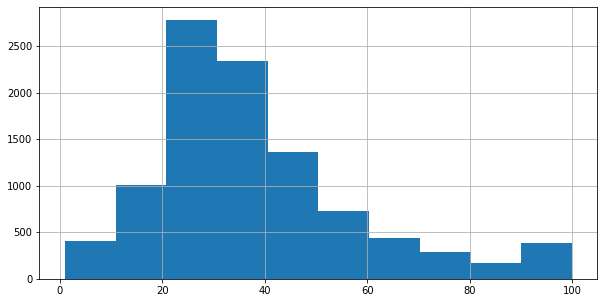

In [4]:
len_df = len(train_df)
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")

train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

In [5]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [6]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

<AxesSubplot:>

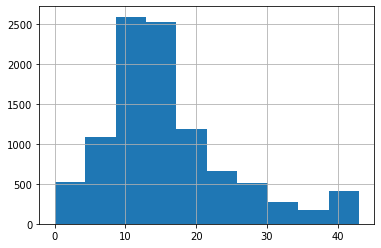

In [7]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

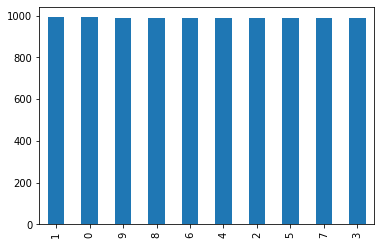

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')
train_df.fold.value_counts().plot.bar()

In [9]:
train_df.head(10)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50,21,9
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25,10,8
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg,0.27,11,6
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg,0.19,7,9
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg,0.27,11,9
5,0,1,1,1,0,0,0,0,1,0,0,0,4,../input/petfinder-pawpularity-score/train/03061e5075bde4995adf6cbf189b0901.jpg,0.04,1,4
6,0,1,1,1,0,0,0,0,1,0,0,0,28,../input/petfinder-pawpularity-score/train/656ad875d187766a5e522b841634662a.jpg,0.28,11,2
7,0,1,1,1,0,0,1,0,0,1,0,0,36,../input/petfinder-pawpularity-score/train/61b3a96da8281908cc2381d96a0849c2.jpg,0.36,15,5
8,0,0,1,1,0,0,0,0,0,0,0,1,20,../input/petfinder-pawpularity-score/train/7f0d60e63067d71624a57102ee473ab4.jpg,0.20,8,6
9,0,1,1,1,0,0,0,0,0,0,0,0,29,../input/petfinder-pawpularity-score/train/c994c9e45ca930c5b38d7670f2cf4e78.jpg,0.29,12,4


In [10]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50,21,9
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25,10,8
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg,0.27,11,6
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg,0.19,7,9
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg,0.27,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,0,0,0,0,26,../input/petfinder-pawpularity-score/train/d9a59cf5f9b386ca222cdc348335c143.jpg,0.26,11,8
9908,0,1,1,1,0,0,0,0,0,0,0,0,65,../input/petfinder-pawpularity-score/train/c3ae20e7de8c74a62a37166bb57f4e2e.jpg,0.65,28,8
9909,0,1,1,0,0,0,0,0,1,1,0,0,38,../input/petfinder-pawpularity-score/train/d9ea120ce5d5213ba2dc31b23de439e6.jpg,0.38,16,8
9910,0,1,1,1,0,0,0,0,0,0,0,0,44,../input/petfinder-pawpularity-score/train/9714de78407cc26d1ecbdcae534e1cee.jpg,0.44,19,6


In [11]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [12]:
def get_data(fold):
    train_df_f = train_df.copy()
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    dls = ImageDataLoaders.from_df(train_df_f,
                               valid_col='is_valid',
                               seed=999,
                               fn_col='path',
                               label_col='norm_score',
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE, 
                               num_workers=8, 
                               item_tfms=Resize(224), 
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    return dls

In [13]:
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [14]:
from fastai.vision.all import *
mixup = MixUp(1.)

In [15]:
def get_learner(fold_num,model):
    data = get_data(fold_num)
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(),cbs=mixup,metrics=petfinder_rmse).to_fp16()
    return learn

In [16]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [17]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [18]:
import gc

In [19]:
new_df

,Pawpularity,Id
0,0.63,0007de18844b0dbbb5e1f607da0606e0
1,0.42,0009c66b9439883ba2750fb825e1d7db
2,0.28,0013fd999caf9a3efe1352ca1b0d937e
3,0.15,0018df346ac9c1d8413cfcc888ca8246
4,0.72,001dc955e10590d3ca4673f034feeef2
...,...,...
9907,0.15,ffbfa0383c34dc513c95560d6e1fdb57
9908,0.70,ffcc8532d76436fc79e50eb2e5238e45
9909,0.20,ffdf2e8673a1da6fb80342fa3b119a20
9910,0.20,fff19e2ce11718548fa1c5d039a5192a


In [20]:
all_preds = []
for i in range(N_FOLDS):
    print(f'Fold {i} results')
    model=torch.load("../input/pwscore/model_swin_"+str(i)+".pt")
    learn = get_learner(i,model)
    dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.2,
                               seed=999,  
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE, 
                               num_workers=8,
                               item_tfms=Resize(224),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    new_test_df["pred"+str(i)]=preds*100
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Fold 0 results


Fold 1 results


Fold 2 results


Fold 3 results


Fold 4 results


Fold 5 results


Fold 6 results


Fold 7 results


Fold 8 results


Fold 9 results


In [21]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [22]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.482500
1,43a2262d7738e3d420d453815151079e,41.447487
2,4e429cead1848a298432a0acad014c9d,40.483967
3,80bc3ccafcc51b66303c2c263aa38486,41.465523
4,8f49844c382931444e68dffbe20228f4,40.539463
